## Image registration based on SIFT feature matching
The algorithm works well when the two images are from the same modality.

In [1]:
import imagej
import os
import numpy as np
import cv2
import ast
from skimage import io, exposure, img_as_uint, img_as_ubyte, img_as_float
from glob import glob
import matplotlib.pyplot as plt

### Initialize PyImageJ
This can take a while for the first run.

In [2]:
ij = imagej.init('sc.fiji:fiji')
print(f"ImageJ version: {ij.getVersion()}")

ImageJ version: 2.3.0/1.53f


### Required functions and ImageJ macro

In [3]:
params = {
    'source_image': '',
    'target_image': '',
    'initial_gaussian_blur': 3.60,
    'steps_per_scale_octave': 3,
    'minimum_image_size': 56,
    'maximum_image_size': 1280, 
    'feature_descriptor_size': 8, 
    'feature_descriptor_orientation_bins': 8,
    'closest/next_closest_ratio': 0.92,
    'filter maximal_alignment_error': 100,
    'minimal_inlier_ratio': 0.05,
    'minimal_number_of_inliers': 7, 
    'expected_transformation': 'Similarity'
}

plugin = "Extract SIFT Correspondences"

macro_openIm = """
#@ String path
open(path);
"""

macro_closeAllIm = """
close("*");
"""

def apply_tform(im, ref, tform, multichannel=False):
    if multichannel:
        height, width, _ = ref.shape
    else:
        height, width = ref.shape
    transformed_img = cv2.warpPerspective(im.astype(np.uint8),
                        tform, (width, height), flags=cv2.INTER_CUBIC)
    return transformed_img

def find_pop_string(msg, s, e):
    check = msg.find(s)
    if check == -1:
        return -1, msg
    found = msg[msg.find(s)+len(s):msg.find(e)+len(e)]
    pop = msg[msg.find(e)+len(e):]
    return found, pop

### Running SIFT registration algorithm in FIJI

In [18]:
### Register pseudo modality generated by CoMIR. CoMIR convert images of different modality into a common intermediate modality (pseudo_modality.ipynb).
# R1_ims = glob('CoMIR\\output\\modalB\\*') ### Moving images.
# R2_ims = glob('CoMIR\\output\\modalA\\*')  ### Fixed images (the order of the file names has to match the moving images' in alphabetical order).
# source_ims = glob('CoMIR\\modalB\\*')  ### Source images to be transformed. Usually, these are the moving images.
# out_path = 'CoMIR\\Registered' ### Folder to save transformed images.

### Register Brightfield images of tissue captured by different microscope.
R1_ims = glob('BF_set\\CAMM\\*') ### Moving images.
R2_ims = glob('BF_set\\Aperio\\*')  ### Fixed images.
source_ims = glob('BF_set\\CAMM\\*')  
out_path = 'BF_set\\Registered' 

os.makedirs(out_path, exist_ok=True)

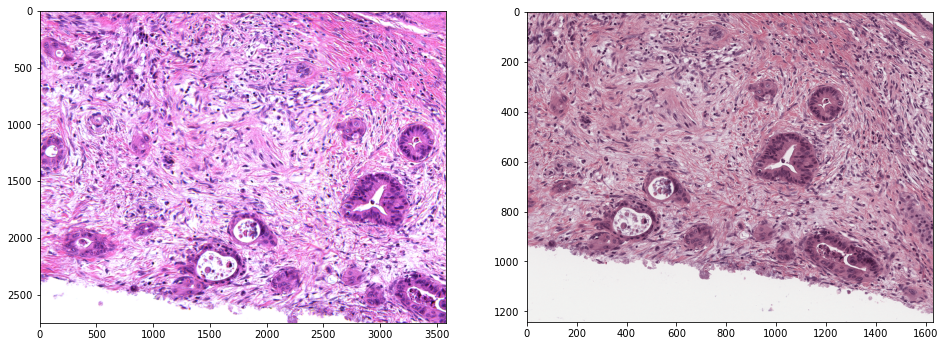

In [19]:
img_1 = io.imread(source_ims[-1])
img_2 = io.imread(R2_ims[-1])
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].imshow(img_1)
ax[1].imshow(img_2)

Extract SIFT features and compute transform matrix, this can take a while. Output are captured from logs.

In [20]:
%%capture output
R1_ims.sort()
R2_ims.sort()
source_ims.sort()
os.makedirs(out_path, exist_ok=True)
for R1_im, R2_im, source_im in zip(R1_ims, R2_ims, source_ims):
    ij.py.run_macro(macro_closeAllIm)
    ij.py.run_macro(macro_openIm, {'path': os.path.join(os.getcwd(), R1_im)})
    ij.py.run_macro(macro_openIm, {'path': os.path.join(os.getcwd(), R2_im)})

    params['source_image'] = os.path.basename(R1_im)
    params['target_image'] = os.path.basename(R2_im)

    result = ij.py.run_plugin(plugin, params)
    ij.py.run_macro(macro_closeAllIm)


In [21]:
output.show()

[java.lang.Enum.toString] Processing SIFT ...[java.lang.Enum.toString] 
[java.lang.Enum.toString]  took 1363ms.[java.lang.Enum.toString] 
[java.lang.Enum.toString] 1450 features extracted.[java.lang.Enum.toString] 
[java.lang.Enum.toString] Processing SIFT ...[java.lang.Enum.toString] 
[java.lang.Enum.toString]  took 1699ms.[java.lang.Enum.toString] 
[java.lang.Enum.toString] 1897 features extracted.[java.lang.Enum.toString] 
[java.lang.Enum.toString] Identifying correspondence candidates using brute force ...[java.lang.Enum.toString] 
[java.lang.Enum.toString]  took 1520ms.[java.lang.Enum.toString] 
[java.lang.Enum.toString] 449 potentially corresponding features identified.[java.lang.Enum.toString] 
[java.lang.Enum.toString] Filtering correspondence candidates by geometric consensus ...[java.lang.Enum.toString] 
[java.lang.Enum.toString]  took 29ms.[java.lang.Enum.toString] 
[java.lang.Enum.toString] 433 corresponding features with an average displacement of 2.056px identified.[java.

### Apply transform matrix to source images 
Scan the output transformation matrix from logs and apply it to the source images

In [22]:
tforms = []
searching = True
msg = output.stderr
tform = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
for i in range(len(source_ims)):
    error_idx = msg.find('No correspondences found.')
    tform_idx = msg.find('AffineTransform')
    if error_idx < tform_idx and error_idx != -1 or tform_idx == -1:
        error, msg = find_pop_string(msg, 'No correspondences found.', 'No correspondences found.')
        if error != -1:
            print(f'Slide registration failed at {source_ims[i]}, no correspondence found. Use previous tform matrix.')
            tforms.append(tform)
    elif error_idx == -1 and tform_idx == -1:
        print('Process done.')
    else:
        t_string, msg = find_pop_string(msg, 'AffineTransform', ']]')
        # t_string = t_string.replace('E-', '')
        tform = ast.literal_eval(t_string)
        tform = np.asarray(tform).reshape((2, 3))
        tform = np.concatenate((tform, np.array([[0, 0, 1]])), 0)
        tforms.append(tform)
        # break

for R2_im, source_im, tform in zip(R2_ims, source_ims, tforms):
    im_source = img_as_ubyte(io.imread(source_im))
    im_target = img_as_ubyte(io.imread(R2_im))

    t_target = apply_tform(im_source, im_target, tform.astype(float), multichannel=(len(im_target.shape)==3))

    im_name = os.path.basename(source_im)
    io.imsave(os.path.join(out_path, im_name), t_target)

Text(0.5, 1.0, 'Target')

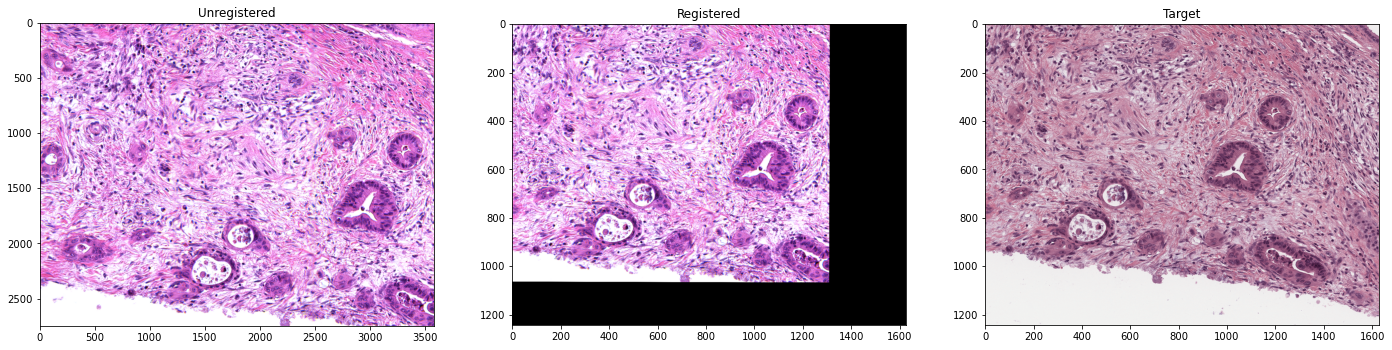

In [23]:
fig, ax = plt.subplots(1, 3, figsize=(24, 8))
ax[0].imshow(im_source)
ax[0].set_title('Unregistered')
ax[1].imshow(t_target)
ax[1].set_title('Registered')
ax[2].imshow(im_target)
ax[2].set_title('Target')